# DoWhy

DoWhy is a causal analysis toolkit from Microsoft Research. It separates causal inference into four stages:

1. Model specification - specify the causal model with a graph
2. Identification - ask whether a given causal query can be estimated from the graph and data
3. Estimation - estimate a given causal effect
4. Refutation - try to refute the causal estimate

## A first analysis 

In [1]:
from dowhy.causal_model import CausalModel
from dowhy.datasets import linear_dataset

In [2]:
data = linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True
)

In [3]:
model = CausalModel(
    data=data['df'],
    treatment=data['treatment_name'],
    outcome=data['outcome_name'],
    graph=data['gml_graph']
)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


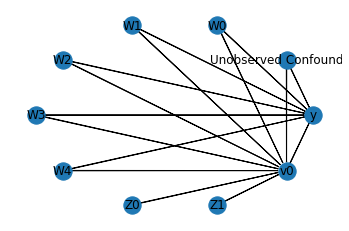

In [4]:
model.view_model()

In [5]:
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'Unobserved Confounders', 'W3', 'W1', 'W2', 'W4']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  


Please respond with 'y' or 'n'


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


In [6]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.propensity_score_matching'
)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2+W4
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:77: FutureWarning: `item` has been deprecated and will be removed in a future version

In [7]:
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W3+W1+W2+W4+w_random
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


Refute: Add a Random Common Cause
Estimated effect:(10.872690171874764,)
New effect:(10.84008953169548,)



/Users/chriswallace/Code/fastforwardlabs/causal-experiments/.venv/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:77: FutureWarning: `item` has been deprecated and will be removed in a future version
  treated_outcome = treated.iloc[indices[i]][self._outcome_name].item()


## A real analysis

Let's try this on real, if cliched, data.

In [8]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

In [9]:
dataset = fetch_california_housing()

In [10]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['Value'] = dataset.target # units of $100,000

In [11]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
housing_graph = """digraph { MedInc -> Value; HouseAge -> Value; AveRooms -> Value; AveBedrms -> Value; Population -> Value; AveOccup -> Value; Latitude -> Value; Longitude -> Value}"""

In [13]:
housing_model = CausalModel(
    data=df,
    treatment="AveBedrms",
    outcome="Value",
    graph=housing_graph
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['AveBedrms'] on outcome ['Value']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


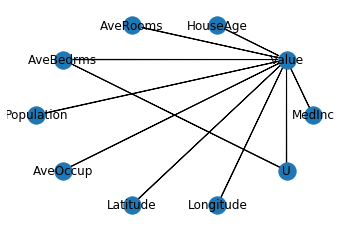

In [14]:
housing_model.view_model()

In [15]:
housing_identified_estimand = housing_model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [16]:
housing_linear_estimate = housing_model.estimate_effect(
    identified_estimand=housing_identified_estimand,
    method_name='backdoor.linear_regression'
)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Value~AveBedrms+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*Longitude+AveBedrms*Latitude+AveBedrms*MedInc+AveBedrms*AveOccup+AveBedrms*Population


In [17]:
print(housing_linear_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                          
────────────(Expectation(Value))
d[AveBedrms]                    
Estimand assumption 1, Unconfoundedness: If U→{AveBedrms} and U→Value then P(Value|AveBedrms,,U) = P(Value|AveBedrms,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Value~AveBedrms+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*Longitude+AveBedrms*Latitude+AveBedrms*MedInc+AveBedrms*AveOccup+AveBedrms*Population
## Estimate
Value: -30.614695758494584



It would appear that increasing the average number of bedrooms for a block of houses by one actually causes a reduction in the house price. That doesn't seem sensible, so let's try to refute our estimate.

In [18]:
housing_refutation = housing_model.refute_estimate(
    housing_identified_estimand,
    housing_linear_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.01
)
print(housing_refutation)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Value~AveBedrms+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*Longitude+AveBedrms*Latitude+AveBedrms*MedInc+AveBedrms*AveOccup+AveBedrms*Population


Refute: Add an Unobserved Common Cause
Estimated effect:(-30.614695758494584,)
New effect:(-30.551001156809303,)



Incredibly, this seems robust to refutation. I'm skeptical, and I think what we're witnessing is that refutation only goes so far - if the graph is incorrect, even the refutation can fail.

## New housing model

In [19]:
new_housing_graph = "digraph { Rich -> MedInc; Rich -> Population; Rich -> AveOccup; AveOccup -> AveRooms; AveOccup -> AveBedrooms; MedInc -> AveRooms; MedInc -> AveBedrms; HouseAge -> Value; AveRooms -> Value; AveBedrms -> Value; Rich -> Value; }"

In [20]:
new_housing_model = CausalModel(
    data=df,
    treatment="AveBedrms",
    outcome="Value",
    graph=new_housing_graph
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['AveBedrms'] on outcome ['Value']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


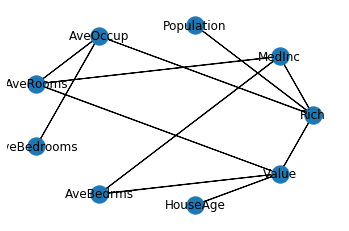

In [21]:
new_housing_model.view_model()

In [22]:
new_identified_estimand = new_housing_model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Rich', 'MedInc']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [23]:
print(new_identified_estimand)

Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(Expectation(Value|MedInc))
d[AveBedrms]                           
Estimand assumption 1, Unconfoundedness: If U→{AveBedrms} and U→Value then P(Value|AveBedrms,MedInc,U) = P(Value|AveBedrms,MedInc)
### Estimand : 2
Estimand name: iv
No such variable found!



In [24]:
new_linear_estimate = new_housing_model.estimate_effect(
    identified_estimand=new_identified_estimand,
    method_name='backdoor.linear_regression'
)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Value~AveBedrms+MedInc+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*AveOccup


In [25]:
print(new_linear_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(Expectation(Value|MedInc))
d[AveBedrms]                           
Estimand assumption 1, Unconfoundedness: If U→{AveBedrms} and U→Value then P(Value|AveBedrms,MedInc,U) = P(Value|AveBedrms,MedInc)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Value~AveBedrms+MedInc+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*AveOccup
## Estimate
Value: -0.17000138464651648



In [26]:
new_refutation = new_housing_model.refute_estimate(
    new_identified_estimand,
    new_linear_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.02,
    effect_strength_on_outcome=0.01
)
print(new_refutation)

new_refutation = new_housing_model.refute_estimate(
    new_identified_estimand,
    new_linear_estimate,
    method_name="random_common_cause",
)
print(new_refutation)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Value~AveBedrms+MedInc+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*AveOccup
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Value~AveBedrms+MedInc+w_random+AveBedrms*AveRooms+AveBedrms*HouseAge+AveBedrms*AveOccup


Refute: Add an Unobserved Common Cause
Estimated effect:(-0.17000138464651648,)
New effect:(-0.1709380793757984,)

Refute: Add a Random Common Cause
Estimated effect:(-0.17000138464651648,)
New effect:(-0.17000523954709568,)

